In [1]:
import os
import csv
import sys
import numpy as np
import cv2          
import time
from torchvision import transforms
import torch
import torch.optim as optim
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from torch.utils.data import Dataset

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

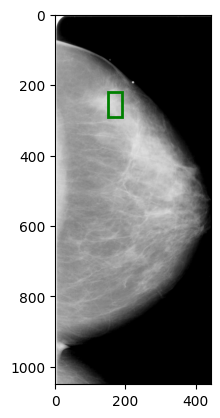

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import csv
import sys
import cv2
def visualize_image_with_boxes(image_path, label_path):
    image = cv2.imread(image_path)
    boxes = []
    with open(label_path, 'r') as file:
        for line in file:
            label, x_center, y_center, width, height = map(float, line.strip().split(' '))
            x_min = int((x_center - width / 2) * image.shape[1])
            y_min = int((y_center - height / 2) * image.shape[0])
            x_max = int((x_center + width / 2) * image.shape[1])
            y_max = int((y_center + height / 2) * image.shape[0])
            boxes.append([x_min, y_min, x_max, y_max])
    fig, ax = plt.subplots(1)
    ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    for box in boxes:
        rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=2, edgecolor='g', facecolor='none')
        ax.add_patch(rect)
    plt.show()
    
file_label = 'Calc-Training_P_00034_RIGHT_CC.txt' 
image_path = os.path.join('/kaggle/input/cv-a4-data/yolo_1k/val/images', file_label.replace('.txt', '.png'))
label_path = os.path.join('/kaggle/input/cv-a4-data/yolo_1k/val/labels', file_label)

visualize_image_with_boxes(image_path, label_path)


Inference

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 127MB/s] 


{'boxes': tensor([[122.7019, 198.4689, 210.0300, 273.1972],
        [206.1262, 320.7335, 387.7227, 487.5839],
        [ 65.4312, 180.7127, 263.9688, 319.4860],
        [233.2913, 364.9981, 380.0254, 467.0320],
        [  3.7084, 930.2009,  30.2187, 960.4360],
        [246.5210, 339.9219, 404.9514, 594.7863],
        [ 98.0894, 183.6353, 220.4995, 292.0598],
        [131.8099, 261.3403, 433.3135, 688.5397],
        [  0.0000, 247.0416, 425.5882, 549.7033],
        [  2.3496, 159.6216, 323.6428, 405.5556],
        [290.6902, 391.3072, 359.9653, 455.5697],
        [199.7056, 322.9257, 321.6600, 440.6406]]), 'labels': tensor([12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12]), 'scores': tensor([0.9370, 0.2900, 0.2078, 0.1885, 0.1658, 0.1307, 0.1202, 0.0918, 0.0633,
        0.0628, 0.0617, 0.0583])}


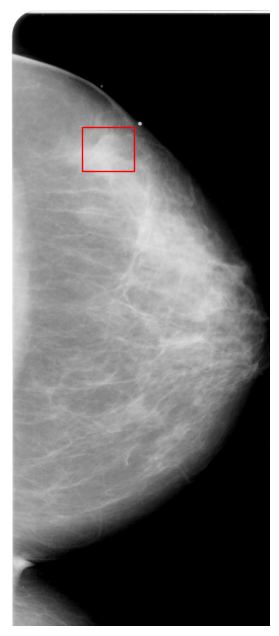

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision.models.detection import fasterrcnn_resnet50_fpn

def load_model(checkpoint_path):
    #model = fasterrcnn_resnet50_fpn(pretrained=False, num_classes=2)
    model = fasterrcnn_resnet50_fpn()
    checkpoint = torch.load(checkpoint_path,map_location=torch.device('cpu'))# when only cpu is present
    #checkpoint = torch.load(checkpoint_path) !uncomment above if device is gpu 
    model.load_state_dict(checkpoint['model_state_dict'])
    return model

def visualize_predicted_boxes(image, predictions):
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    ax = plt.gca()

#     for box in predictions['boxes'][0]:
#         print(box)
    box = predictions['boxes'][0].tolist()

    
    x_min, y_min, x_max, y_max = box
    width = x_max - x_min
    height = y_max - y_min
    rect = patches.Rectangle((x_min, y_min), width, height, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

    plt.axis('off')
    plt.show()

def main():
    checkpoint_path = "/kaggle/input/finetunepretrained-rcnn/model.pt"
    model = load_model(checkpoint_path)
    model.to(device)
    model.eval()

    image_path = "/kaggle/input/cv-a4-data/yolo_1k/val/images/Calc-Training_P_00034_RIGHT_CC.png"  # Provide the path to the image
    image = cv2.imread(image_path)
   # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

    #image_tensor = torch.tensor(image.transpose(2, 0, 1), dtype=torch.float32).unsqueeze(0).to(device)
    transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

    image_tensor = transform(image)
    image_tensor = image_tensor.unsqueeze(0).to(device)
    # Perform inference
    with torch.no_grad():
        predictions = model(image_tensor)[0]
#         print(model(image_tensor))
        print(predictions)

    visualize_predicted_boxes(image, predictions)

if __name__ == "__main__":
    main()


In [ ]:
def get_model(num_classes):
    # Load a model pre-trained on COCO
    weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
    model = fasterrcnn_resnet50_fpn(weights=weights)

    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    model.to(device)

    return model

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.images_folder_path = os.path.join(folder_path, 'images')
        self.labels_folder_path = os.path.join(folder_path, 'labels')
        # self.mean = mean
        # self.var = var
        self.transform = transform
        self.filenames = [f for f in os.listdir(self.images_folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

    def get_all_images_and_boxes(self):
        data = []
        for filename in self.filenames:
            image_path = os.path.join(self.images_folder_path, filename)
            image = cv2.imread(image_path)
            #image = cv2.resize(image, (224, 224))
            #image = (image - self.mean) / np.sqrt(self.var)
            image = torch.tensor(image.transpose(2, 0, 1), dtype=torch.float32)

            label_file_path = os.path.join(self.labels_folder_path, filename.replace('.png', '.txt').replace('.jpg', '.txt'))
            boxes = []
            if os.path.isfile(label_file_path):
                with open(label_file_path, 'r') as file:
                    for line in file:
                        label, x_center, y_center, width, height = map(float, line.strip().split(' '))
                        x_min = x_center - width / 2
                        y_min = y_center - height / 2
                        x_max = x_min + width
                        y_max = y_min + height
                        boxes.append([label, x_min, y_min, x_max, y_max])

            if boxes:
                labels = torch.tensor([b[0] for b in boxes], dtype=torch.int64)
                boxes = torch.tensor(boxes, dtype=torch.float32)
                boxes = boxes[:, 1:]
                #data.append((image, {'boxes': boxes, 'labels': labels}))
                data.append((image.to(device), {'boxes': boxes.to(device), 'labels': labels.to(device)}))


        return data

In [ ]:
def get_mean_var(train_folder, val_folder):
    sum_values = 0
    sum_squares = 0
    num_pixels = 0

    for folder in [train_folder, val_folder]:
        images_folder_path = os.path.join(folder, 'images')
        for filename in os.listdir(images_folder_path):
            if filename.endswith(('.jpg', '.jpeg', '.png')):  
                image_path = os.path.join(images_folder_path, filename)
                image = cv2.imread(image_path)
                # Resize image to 224x224
                image = cv2.resize(image, (224, 224))
                pixels = image.flatten()
                sum_values += np.sum(pixels)
                sum_squares += np.sum(np.square(pixels))
                num_pixels += len(pixels)

    mean = sum_values / num_pixels
    var = sum_squares / num_pixels - mean**2
    if np.any(var <= 0):
        print("Negative variance encountered; adjusting.")
        var = np.maximum(var, 1e-10)

    return mean, var

In [ ]:
def create_batches(data, batch_size):
    for i in range(0, len(data), batch_size):
        yield data[i:i+batch_size]

def train_model(model, optimizer, train_data, val_data, num_epochs):
    print("training the model")
    best_val_loss = float('inf')
    patience = 10
    no_improvement_count = 0
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        # Shuffle data
        np.random.shuffle(train_data)
        # Training
        model.train()  
        avg_train_loss = 0.0
        num_batches = 0.0
        for batch in create_batches(train_data, batch_size=4):
            images = [x[0] for x in batch]
            targets = [x[1] for x in batch]
            optimizer.zero_grad()
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            avg_train_loss += losses.item()
            num_batches += 1
#             print(avg_train_loss)
#             break
            losses.backward()  # Backpropagation
            optimizer.step()  # Update model weights
            
        avg_train_loss /= num_batches
        train_losses.append(avg_train_loss)

        #Validation 
        #model.eval()
#         np.random.shuffle(val_data)
        avg_val_loss = 0.0
        with torch.no_grad():
            for batch in create_batches(val_data, batch_size=4):
                images = [x[0] for x in batch]
                targets = [x[1] for x in batch]
                val_loss_dict = model(images, targets)
                val_losses = sum(loss for loss in val_loss_dict.values())
                avg_val_loss += val_losses.item()
                num_batches += 1
            avg_val_loss /= num_batches
            val_losses.append(avg_val_loss)
        
        # # Validation 
        # model.eval()  
        # avg_val_loss = 0.0
        # with torch.no_grad():
        #     for batch in create_batches(val_data, batch_size=4):
        #         images = [x[0] for x in batch]
        #         targets = [x[1] for x in batch]
        #         val_loss_dict = model(images, targets)
        #         val_losses = sum(loss for loss in val_loss_dict.values())
        #         avg_val_loss += val_losses.item()
        #         num_batches += 1
        #     avg_val_loss /= num_batches
        
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
        # Check for early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            no_improvement_count = 0
            torch.save({'model_state_dict': model.state_dict()}, "model.pt")
        else:
            no_improvement_count += 1
            if no_improvement_count == patience and epoch > 10:
                print("Validation loss did not improve. Stopping early.")
                break
                
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

In [ ]:
def main():

    # train_folder = sys.argv[2]
    # val_folder = sys.argv[3]

    train_folder = "//kaggle/input/cv-a4-data/yolo_1k/train"
    val_folder = "/kaggle/input/cv-a4-data/yolo_1k/val"

    # train_folder = "train"
    # val_folder = "val"

#     mean, var = get_mean_var(train_folder, val_folder)
#     print(f"mean and var of the data is {mean} & {var}")

    # train_data = ImageDataset(train_folder, mean, var).get_all_images_and_boxes()
    # val_data = ImageDataset(val_folder, mean, var).get_all_images_and_boxes()

    train_data = ImageDataset(train_folder).get_all_images_and_boxes()
    val_data = ImageDataset(val_folder).get_all_images_and_boxes()
    print("train and val data created")

    # Define the device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    #model_type = int(sys.argv[1])      # 1 for rcnn and 2 for transformer
    model_type = 2

    if model_type == 1:

        num_classes = 2  # tumor (class 0) + no Tumor (class 1)
        learning_rate = 0.0001
        num_epochs = 100

        # Model definition
       # model = fasterrcnn_resnet50_fpn(weights = None, num_classes=num_classes).to(device)
        
       # model = fasterrcnn_resnet50_fpn(weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT, num_classes=num_classes).to(device)

        model = get_model(num_classes)

        # Optimizer and loss function
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
       # criterion = torch.nn.SmoothL1Loss()  # Use smooth L1 loss for bounding box regression

        train_model(model, optimizer, train_data, val_data, num_epochs)

        # Save the trained model
        # torch.save({
        #     'model_state_dict': model.state_dict(),
        #     'mean': mean,
        #     'var': var
        # }, "model.pt")  

         

    
    if model_type == 2:
        
        num_classes = 2  # tumor (class 0) + no Tumor (class 1)
        learning_rate = 0.0001
        num_epochs = 100
        
        # Model definition
        model = DetrForObjectDetection.from_pretrained('facebook/detr-resnet-50').to(device)
        coco detection
        config = DetrConfig.from_pretrained('facebook/detr-resnet-50')
        config.num_labels = 1
        model = DetrForObjectDetection(config)
        #model = get_model(num_classes)

        # Optimizer and loss function
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
       # criterion = torch.nn.SmoothL1Loss()  # Use smooth L1 loss for bounding box regression

        train_model(model, optimizer, train_data, val_data, num_epochs)
             

if __name__ == "__main__":
    main()

# Gradient Experiment

tensor([[[[ 2.2489,  2.2489,  2.2489,  ...,  1.4612,  1.5639,  1.6153],
          [ 2.2489,  2.2489,  2.2489,  ...,  2.0434,  2.0777,  2.0777],
          [ 2.2489,  2.2489,  2.2489,  ...,  2.1633,  2.1462,  2.1462],
          ...,
          [ 2.2489,  2.2489,  2.2318,  ..., -2.1179, -2.1179, -2.1179],
          [ 2.2489,  2.2489,  2.2147,  ..., -2.1179, -2.1179, -2.1179],
          [ 2.2489,  2.2489,  2.2318,  ..., -2.1179, -2.1179, -2.1179]],

         [[ 2.4286,  2.4286,  2.4286,  ...,  1.6232,  1.7283,  1.7808],
          [ 2.4286,  2.4286,  2.4286,  ...,  2.2185,  2.2535,  2.2535],
          [ 2.4286,  2.4286,  2.4286,  ...,  2.3410,  2.3235,  2.3235],
          ...,
          [ 2.4286,  2.4286,  2.4111,  ..., -2.0357, -2.0357, -2.0357],
          [ 2.4286,  2.4286,  2.3936,  ..., -2.0357, -2.0357, -2.0357],
          [ 2.4286,  2.4286,  2.4111,  ..., -2.0357, -2.0357, -2.0357]],

         [[ 2.6400,  2.6400,  2.6400,  ...,  1.8383,  1.9428,  1.9951],
          [ 2.6400,  2.6400,  

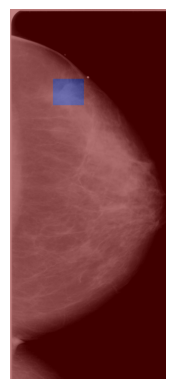

In [12]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.models.detection.roi_heads import RoIHeads
from torchvision import transforms

def load_model(checkpoint_path):
    #model = fasterrcnn_resnet50_fpn(pretrained=False, num_classes=2)
    model = fasterrcnn_resnet50_fpn()
    checkpoint = torch.load(checkpoint_path,map_location=torch.device('cpu')) #when only cpu is present
    #checkpoint = torch.load(checkpoint_path) !uncomment above if device is gpu 
    model.load_state_dict(checkpoint['model_state_dict'])
    return model

def preprocess_image(image_path):
    # Load and preprocess the image
    image = cv2.imread(image_path)
    transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

    image_tensor = transform(image)
    image_tensor = image_tensor.unsqueeze(0).to(device)
    print(image_tensor)
    return image_tensor

def visualize_heatmap(image, heatmap):
    # Overlay the heatmap on the original image
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    overlaid_image = cv2.addWeighted(image, 0.5, heatmap, 0.5, 0)
    
    # Display the overlaid image
    plt.imshow(overlaid_image)
    plt.axis('off')
    plt.show()

def generate_heatmap(image_path, model):
    # Load and preprocess the image
    image_tensor = preprocess_image(image_path)
    model.eval()
    # Perform inference
    with torch.no_grad():
        predictions = model(image_tensor)[0]
    
    # Extract the highest confidence bounding box
    scores = predictions['scores']
    highest_confidence_index = torch.argmax(scores)
    box = predictions['boxes'][highest_confidence_index].cpu().numpy().astype(int)
    
    # Calculate the GradCAM or Attention Map for the highest confidence bounding box (you can choose one)
    # Here you would implement your GradCAM or Attention Map calculation method
    
    # For illustration purposes, let's create a dummy heatmap
    heatmap = np.zeros((image_tensor.shape[2], image_tensor.shape[3]))
    heatmap[box[1]:box[3], box[0]:box[2]] = 1.0  # Dummy heatmap for the bounding box
    
    # Visualize the heatmap overlaid on the original image
    image = cv2.imread(image_path)
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    visualize_heatmap(image, heatmap)

def main():
    # Define the path to the image and the trained model checkpoint
    image_path = "/kaggle/input/cv-a4-data/yolo_1k/val/images/Calc-Training_P_00034_RIGHT_CC.png"
    checkpoint_path = "/kaggle/input/finetunepretrained-rcnn/model.pt"
    
    # Load the model
    model = load_model(checkpoint_path)
    
    # Generate and visualize the heatmap
    generate_heatmap(image_path, model)

if __name__ == "__main__":
    main()


In [13]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision import transforms
from torchvision.models.detection.image_list import ImageList

def load_model(checkpoint_path):
    model = fasterrcnn_resnet50_fpn()
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint['model_state_dict'])
    return model

def preprocess_image(image_path):
    image = cv2.imread(image_path)
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image_tensor = transform(image)
    image_tensor = image_tensor.unsqueeze(0)  # Add batch dimension
    return image_tensor

def generate_eigencam(image_tensor, model, target_layer):
    model.eval()

    image_list = ImageList(image_tensor, [(image_tensor.shape[-2], image_tensor.shape[-1])])
   
    features = model.backbone(image_list.tensors)
    
    print(features)
 
    proposals, _ = model.rpn(image_list, features)
    #print(proposals)
   
    
    image_shapes = [image_tensor.shape[-2:]]
    
    box_features = model.roi_heads.box_roi_pool(features, proposals,image_shapes)
    box_features = model.roi_heads.box_head(box_features)

    # Predict class scores and bounding box offsets
    class_logits, _ = model.roi_heads.box_predictor(box_features)
    
    #print(class_logits)
    
    # Get the predicted class index
    pred_class = class_logits.argmax(dim=1)
    
    #print(pred_class)
    
    # Take the mean of the prediction score
    pred_class_score = class_logits[0][pred_class]
    pred_class_score_mean = pred_class_score.mean()
    
    # Compute gradients
    model.zero_grad()
    pred_class_score_mean.backward()
    
    # Get gradients from target layer
    if isinstance(features, dict):
        target_layer_features = features['3']
    else:
        target_layer_features = features  # If features is not a dictionary, assume it's a tensor
    
    gradients = target_layer_features.grad
    
    # Compute the Hessian matrix
    H = torch.autograd.functional.hessian(pred_class_score_mean, target_layer_features)
    
    # Compute the Eigenvalues and Eigenvectors of the Hessian matrix
    eigvals, eigvecs = torch.symeig(H, eigenvectors=True)
    
    # Choose the Eigenvector corresponding to the maximum Eigenvalue
    max_eigvec = eigvecs[:, -1]
    
    # Compute the weighted sum of feature maps using the maximum Eigenvector
    eigencam = torch.matmul(gradients.transpose(1, 0), max_eigvec)
    
    # ReLU on the eigencam
    eigencam = np.maximum(eigencam.detach().numpy(), 0)
    
    return eigencam




def visualize_eigencam(image, eigencam):
    eigencam = cv2.resize(eigencam, (image.shape[1], image.shape[0]))
    eigencam = np.uint8(255 * eigencam)
    eigencam = cv2.applyColorMap(eigencam, cv2.COLORMAP_JET)
    overlaid_image = cv2.addWeighted(image, 0.5, eigencam, 0.5, 0)
    plt.imshow(overlaid_image)
    plt.axis('off')
    plt.show()

def main():
    image_path = "/kaggle/input/cv-a4-data/yolo_1k/val/images/Calc-Training_P_00034_RIGHT_CC.png"
    checkpoint_path = "/kaggle/input/finetunepretrained-rcnn/model.pt"
    model = load_model(checkpoint_path)
    image_tensor = preprocess_image(image_path)
    target_layer = 4  # Choose the target layer index, e.g., for ResNet, it's usually the last convolutional layer
    eigencam = generate_eigencam(image_tensor, model, target_layer)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    visualize_eigencam(image, eigencam)

if __name__ == "__main__":
    main()


OrderedDict([('0', tensor([[[[ 1.7934,  2.5873,  2.2943,  ...,  2.0871,  2.4096,  1.0903],
          [ 2.3123,  3.2068,  3.1907,  ...,  2.7354,  2.6148,  1.2465],
          [ 2.6873,  3.6044,  3.2839,  ...,  3.0963,  3.6981,  2.1098],
          ...,
          [ 1.3850,  2.0932,  2.0316,  ...,  2.7574,  3.3759,  1.4769],
          [ 1.5188,  2.1612,  2.1171,  ...,  2.9833,  3.6571,  1.6604],
          [ 0.1740,  0.6316,  0.6008,  ...,  1.5953,  2.0313,  0.4645]],

         [[ 1.6095,  1.3165,  1.3189,  ...,  1.0578,  1.1459,  0.2631],
          [ 2.0087,  1.1720,  0.9023,  ...,  0.9342,  1.3090,  0.0978],
          [ 1.7029,  0.9801,  0.8950,  ...,  1.2157,  1.4350,  0.3878],
          ...,
          [ 0.5045, -0.2167, -0.1687,  ...,  0.6487,  0.6141, -0.1531],
          [ 0.4536,  0.1667,  0.1505,  ...,  0.4625,  0.5267, -0.1775],
          [ 0.5033, -1.0832, -0.8197,  ..., -0.4841, -0.4680, -0.7980]],

         [[ 2.2221,  2.7549,  2.5733,  ...,  1.9758,  2.4355,  0.8799],
          [

/tmp/ipykernel_33/674959921.py:68: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:489.)
  gradients = target_layer_features.grad


TypeError: 'Tensor' object is not callable

In [37]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision import transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.models.detection.roi_heads import RoIHeads
from torchvision import transforms

def load_model(checkpoint_path):
    model = fasterrcnn_resnet50_fpn()
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu')) # When only CPU is present
    model.load_state_dict(checkpoint['model_state_dict'])
    return model

def preprocess_image(image_path):
    image = cv2.imread(image_path)
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image_tensor = transform(image)
    image_tensor = image_tensor.unsqueeze(0)
    return image_tensor

def visualize_heatmap(image, heatmap):
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    overlaid_image = cv2.addWeighted(image, 0.5, heatmap, 0.5, 0)
    
    plt.imshow(overlaid_image)
    plt.axis('off')
    plt.show()

def generate_heatmap(image_path, model):
    image_tensor = preprocess_image(image_path)
    model.eval()
    
    # Define the target class (e.g., the class with the highest confidence)
    with torch.no_grad():
        predictions = model(image_tensor)[0]
        scores = predictions['scores']
        highest_confidence_index = torch.argmax(scores)
        target_class = highest_confidence_index.item()
    
    # Get the feature maps from the model
    feature_extractor = model.backbone.body
    feature_maps = feature_extractor(image_tensor)
    
    # Calculate the gradients of the output with respect to the feature maps
    model.zero_grad()
    predictions['boxes'].requires_grad = True
    predictions['boxes'].backward(gradient=torch.ones_like(predictions['boxes']), retain_graph=True)
    gradients = predictions['boxes'].grad
    
    # Calculate the GradCAM heatmap
    if gradients is not None:
        # Calculate the average gradient for each box
        pooled_gradients = torch.mean(gradients, dim=0, keepdim=True)
        
        # Get the feature maps corresponding to the last layer
        activations = feature_maps['3']
        
        # Iterate over each box
        for i in range(len(predictions['boxes'])):
            # Get the gradients for the ith box
            box_gradients = pooled_gradients[i].view(1, 1, 1, -1)
            
            # Get the feature map for the ith box
            activation = activations[i].unsqueeze(0)
            
            # Element-wise multiplication
            weighted_activation = activation * box_gradients
            
            # Sum along the channel dimension
            heatmap_i = weighted_activation.sum(dim=1, keepdim=True)
            
            # Combine heatmaps for all boxes
            if i == 0:
                heatmap = heatmap_i
            else:
                heatmap = torch.cat((heatmap, heatmap_i), dim=0)
        
        # Convert the heatmap to numpy array
        heatmap = heatmap.squeeze().cpu().numpy()
        heatmap = np.maximum(heatmap, 0)  # ReLU on the heatmap
        
        # Normalize the heatmap
        heatmap /= np.max(heatmap)
        
        # Visualize the heatmap overlaid on the original image
        image = cv2.imread(image_path)
        visualize_heatmap(image, heatmap)
    else:
        print("Gradients are None. Unable to compute GradCAM heatmap.")



def main():
    image_path = "/kaggle/input/cv-a4-data/yolo_1k/val/images/Calc-Training_P_00034_RIGHT_CC.png"
    checkpoint_path = "/kaggle/input/finetunepretrained-rcnn/model.pt"
    
    model = load_model(checkpoint_path)
    
    generate_heatmap(image_path, model)

if __name__ == "__main__":
    main()


RuntimeError: The size of tensor a (14) must match the size of tensor b (4) at non-singleton dimension 3

In [16]:
fasterrcnn_resnet50_fpn(pretrained=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 88.0MB/s] 


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(